In [1]:
import os
from six import string_types
import numpy as np
import pandas as pd
from skimage import io
from glob import glob
from tqdm import tqdm

from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

%matplotlib inline


In [2]:
PLANET_KAGGLE_ROOT = os.path.abspath("../data/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_JPEG_DIR_TEST = os.path.join(PLANET_KAGGLE_ROOT, 'test-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR_TEST)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [3]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)

# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [4]:
# Preprocess labels
label_map = {l: i for i, l in enumerate(label_list)}

# Prepare array of labels
y_train = []

for f, tags in tqdm(labels_df.values, miniters=1000):
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    y_train.append(targets)

y_train = np.array(y_train, np.uint8)

100%|██████████| 40479/40479 [00:00<00:00, 188308.32it/s]


In [5]:
# Print all unique classes
print(label_map)

{'haze': 0, 'primary': 1, 'agriculture': 2, 'clear': 3, 'water': 4, 'habitation': 5, 'road': 6, 'cultivation': 7, 'slash_burn': 8, 'cloudy': 9, 'partly_cloudy': 10, 'conventional_mine': 11, 'bare_ground': 12, 'artisinal_mine': 13, 'blooming': 14, 'selective_logging': 15, 'blow_down': 16}


In [6]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

image_name                                       tags  haze  primary  \
0    train_0                               haze primary     1        1   
1    train_1            agriculture clear primary water     0        1   
2    train_2                              clear primary     0        1   
3    train_3                              clear primary     0        1   
4    train_4  agriculture clear habitation primary road     0        1   

   agriculture  clear  water  habitation  road  cultivation  slash_burn  \
0            0      0      0           0     0            0           0   
1            1      1      1           0     0            0           0   
2            0      1      0           0     0            0           0   
3            0      1      0           0     0            0           0   
4            1      1      0           1     1            0           0   

   cloudy  partly_cloudy  conventional_mine  bare_ground  artisinal_mine  \
0       0              0                  0            0               0   
1       0              0                  0            0               0   
2       0              0                  0            0               0   
3       0              0                  0            0               0   
4       0              0                  0            0               0   

   blooming  selective_logging  blow_down  
0         0                  0          0  
1         0                  0          0  
2         0                  0          0  
3         0                  0          0  
4         0                  0          0

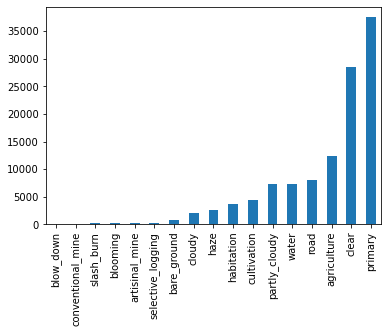

In [7]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

In [8]:
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

In [9]:
def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            ##########print('Found image {}'.format(path))
            return io.imread(path)
    # if you reach this line, you didn't find the image you're looking for
    print('Load failed: could not find image {}'.format(path))
    
def sample_to_fname(sample_df, row_idx, suffix='jpg'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.at[sample_df.index[row_idx], 'image_name']
    return '{}.{}'.format(fname, suffix)

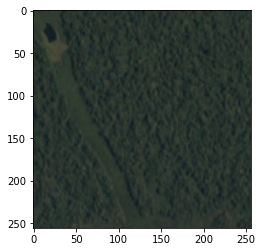

In [10]:
sampled_images = sample_images(['clear', 'road', 'water'], n=1)

for i in range(len(sampled_images)):
    jpg = sample_to_fname(sampled_images, i, 'jpg')

    try:
        jpg_img = load_image(jpg)[:,:,:3]

        fig = plt.figure()
        fig.set_size_inches(4, 4)
        plt.imshow(jpg_img)
    except:
        continue

### Embeddings

In [11]:
#FEATURES_KAGGLE = os.path.abspath("../data/features/Kaggle")

#features_bigearthnet = np.load(os.path.join(FEATURES_KAGGLE, 'features_bigearthnet_Kaggle.npy'))
#features_EuroSAT = np.load(os.path.join(FEATURES_KAGGLE, 'features_EuroSAT_Kaggle.npy'))
#features_ResNet50 = np.load(os.path.join(FEATURES_KAGGLE, 'features_ImageNet-ResNet50_Kaggle.npy'))
#features_Resic45 = np.load(os.path.join(FEATURES_KAGGLE, 'features_Resic45_Kaggle.npy'))
#features_So2Sat = np.load(os.path.join(FEATURES_KAGGLE, 'features_So2Sat_Kaggle.npy'))
#features_Tile2Vec = np.load(os.path.join(FEATURES_KAGGLE, 'features_Tile2Vec_Kaggle.npy'))
#features_UCMerced = np.load(os.path.join(FEATURES_KAGGLE, 'features_UC_Merced_Kaggle.npy'))
#features_InceptionV3 = np.load(os.path.join(FEATURES_KAGGLE, 'features_InceptionV3_pool_Kaggle.npy'))

### t-SNE

In [12]:
#print(features_bigearthnet.shape)
#tsne_bigearthnet = TSNE(
#    n_components=2,
#    init='random', # pca
#    random_state=101,
#    method='barnes_hut',
#    n_iter=500,
#    verbose=2
#).fit_transform(features_bigearthnet)

In [13]:
TSNE_KAGGLE = os.path.abspath("../data/features/Kaggle/TSNE")

tsne_bigearthnet = np.load(os.path.join(TSNE_KAGGLE, 'tsne_bigearthnet.npy'))
tsne_EuroSAT = np.load(os.path.join(TSNE_KAGGLE, 'tsne_EuroSAT.npy'))
tsne_ResNet50 = np.load(os.path.join(TSNE_KAGGLE, 'tsne_ResNet50.npy'))
tsne_Resic45 = np.load(os.path.join(TSNE_KAGGLE, 'tsne_Resic45.npy'))
tsne_So2Sat = np.load(os.path.join(TSNE_KAGGLE, 'tsne_So2Sat.npy'))
tsne_Tile2Vec = np.load(os.path.join(TSNE_KAGGLE, 'tsne_Tile2Vec.npy'))
tsne_UCMerced = np.load(os.path.join(TSNE_KAGGLE, 'tsne_UCMerced.npy'))
tsne_InceptionV3 = np.load(os.path.join(TSNE_KAGGLE, 'tsne_InceptionV3.npy'))


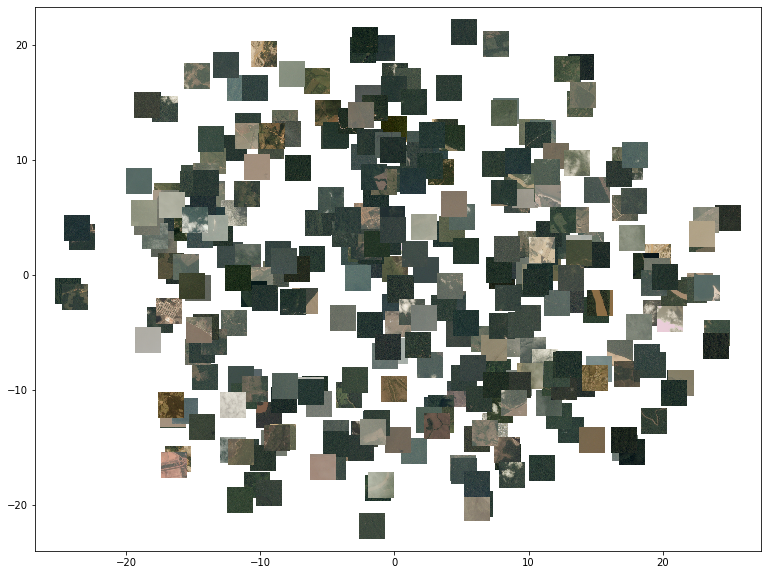

In [14]:
# Plot the subset of images in a two dimensional representation
n_imgs = 350
image_paths = sorted(glob('../data/train-jpg/*.jpg'))[0:n_imgs]

def imscatter(x, y, images, ax=None, zoom=0.1):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
imscatter(tsne_bigearthnet[0:n_imgs,0], tsne_bigearthnet[0:n_imgs,1], [plt.imread(image_paths[i]) for i in range(n_imgs)])

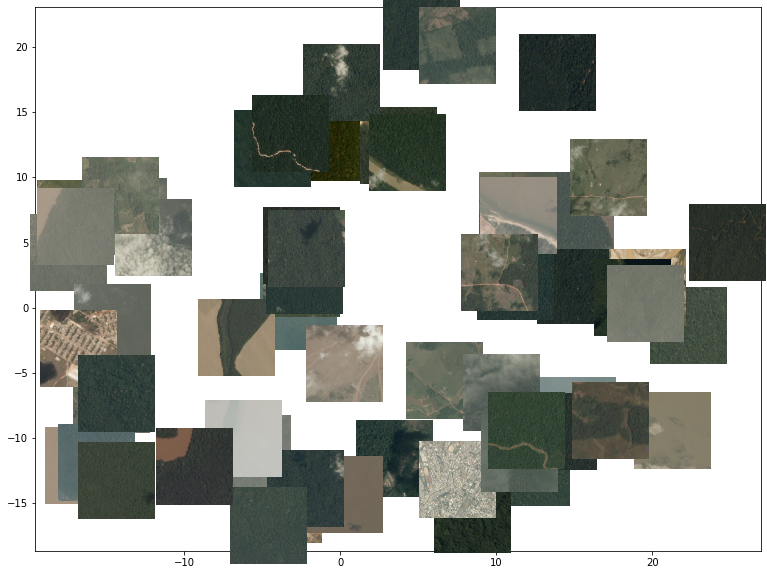

In [15]:
# Subset of images for clustering
n_imgs = 60
offset = 100
image_paths = sorted(glob('../data/train-jpg/*.jpg'))[0:offset + n_imgs]

# Plot the subset of images in a two dimensional representation
def imscatter(x, y, images, ax=None, zoom=0.3):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
imscatter(tsne_bigearthnet[offset:offset + n_imgs, 0], tsne_bigearthnet[offset:offset + n_imgs, 1], [plt.imread(image_paths[offset + i]) for i in range(n_imgs)])

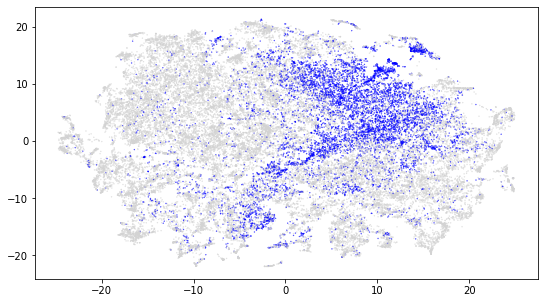

In [16]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_bigearthnet[:, 0], tsne_bigearthnet[:, 1], c=color, s=0.1, cmap='Scatter');

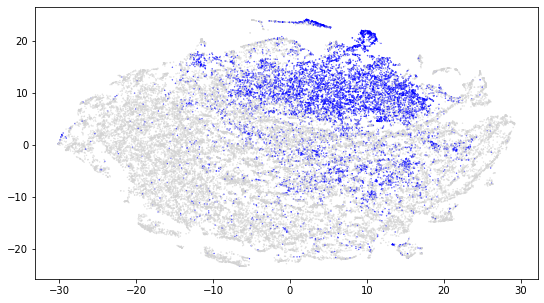

In [17]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_EuroSAT[:, 0], tsne_EuroSAT[:, 1], c=color, s=0.1, cmap='Scatter');

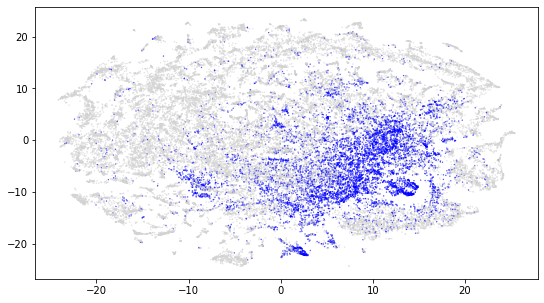

In [18]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_ResNet50[:, 0], tsne_ResNet50[:, 1], c=color, s=0.1, cmap='Scatter');

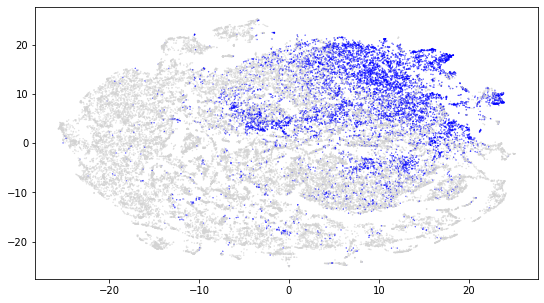

In [19]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_Resic45[:, 0], tsne_Resic45[:, 1], c=color, s=0.1, cmap='Scatter');

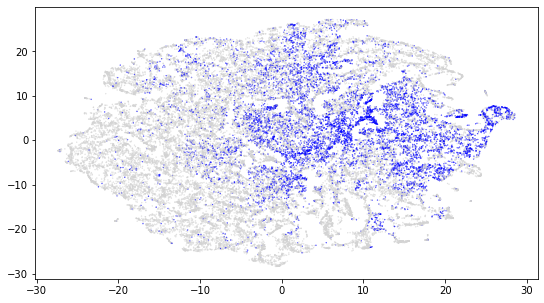

In [20]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_So2Sat[:, 0], tsne_So2Sat[:, 1], c=color, s=0.1, cmap='Scatter');

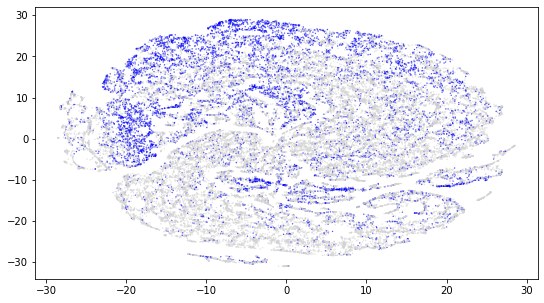

In [21]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_Tile2Vec[:, 0], tsne_Tile2Vec[:, 1], c=color, s=0.1, cmap='Scatter');

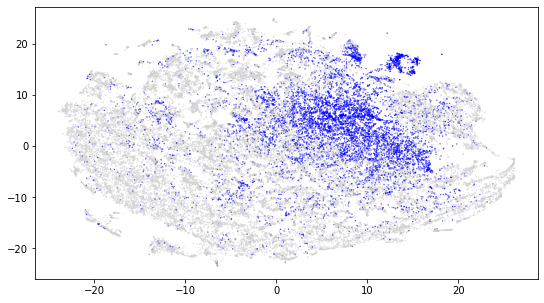

In [22]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_UCMerced[:, 0], tsne_UCMerced[:, 1], c=color, s=0.1, cmap='Scatter');

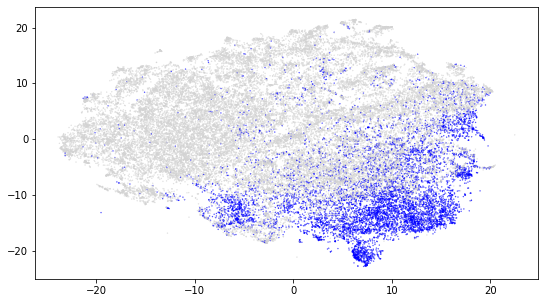

In [23]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(tsne_InceptionV3[:, 0], tsne_InceptionV3[:, 1], c=color, s=0.1, cmap='Scatter');

##### Weather

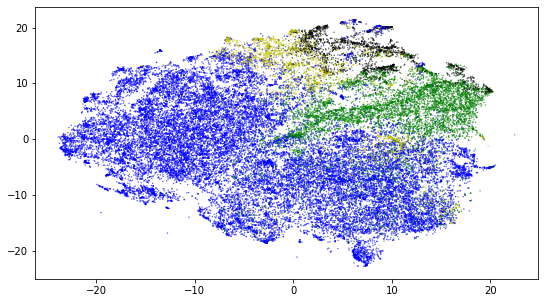

In [24]:
color = []
for i in range(len(y_train)):
    if y_train[i,0] == 1: #haze
        color.append('y')
    elif y_train[i,3] == 1: #clear
        color.append('b')
    elif y_train[i,9] == 1: #cloudy
        color.append('k')
    else: #partly cloudy
        color.append('g')
        
plt.figure(figsize=(9,5))
plt.scatter(tsne_InceptionV3[:, 0], tsne_InceptionV3[:, 1], c=color, s=0.1, cmap='Spectral');

### PCA

In [25]:
#pca_bigearthnet = PCA(n_components=17).fit_transform(features_bigearthnet)

In [26]:
PCA_KAGGLE = os.path.abspath("../data/features/Kaggle/PCA")

pca_bigearthnet = np.load(os.path.join(PCA_KAGGLE, 'pca_bigearthnet.npy'))
pca_EuroSAT = np.load(os.path.join(PCA_KAGGLE, 'pca_EuroSAT.npy'))
pca_ResNet50 = np.load(os.path.join(PCA_KAGGLE, 'pca_ResNet50.npy'))
pca_Resic45 = np.load(os.path.join(PCA_KAGGLE, 'pca_Resic45.npy'))
pca_So2Sat = np.load(os.path.join(PCA_KAGGLE, 'pca_So2Sat.npy'))
pca_Tile2Vec = np.load(os.path.join(PCA_KAGGLE, 'pca_Tile2Vec.npy'))
pca_UCMerced = np.load(os.path.join(PCA_KAGGLE, 'pca_UCMerced.npy'))
pca_InceptionV3 = np.load(os.path.join(PCA_KAGGLE, 'pca_InceptionV3.npy'))


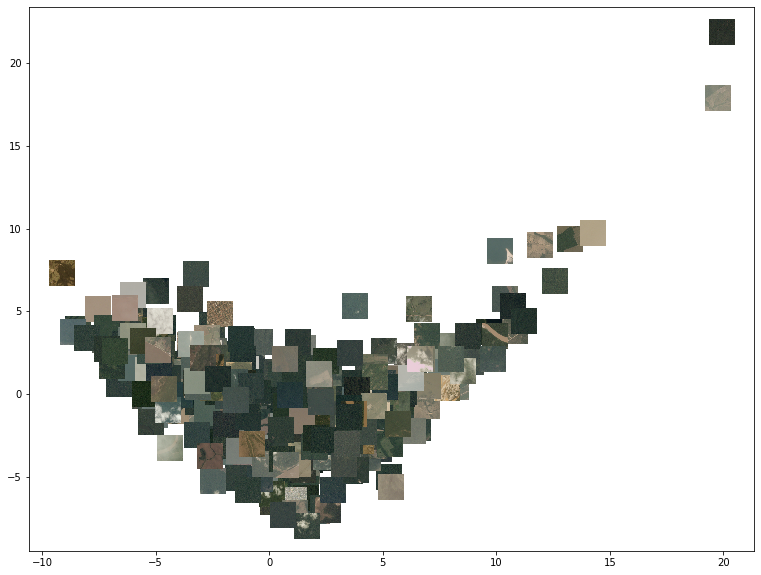

In [27]:
# Plot the subset of images in a two dimensional representation
n_imgs = 350
image_paths = sorted(glob('../data/train-jpg/*.jpg'))[0:n_imgs]

def imscatter(x, y, images, ax=None, zoom=0.1):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
imscatter(pca_bigearthnet[0:n_imgs,0], pca_bigearthnet[0:n_imgs,1], [plt.imread(image_paths[i]) for i in range(n_imgs)])

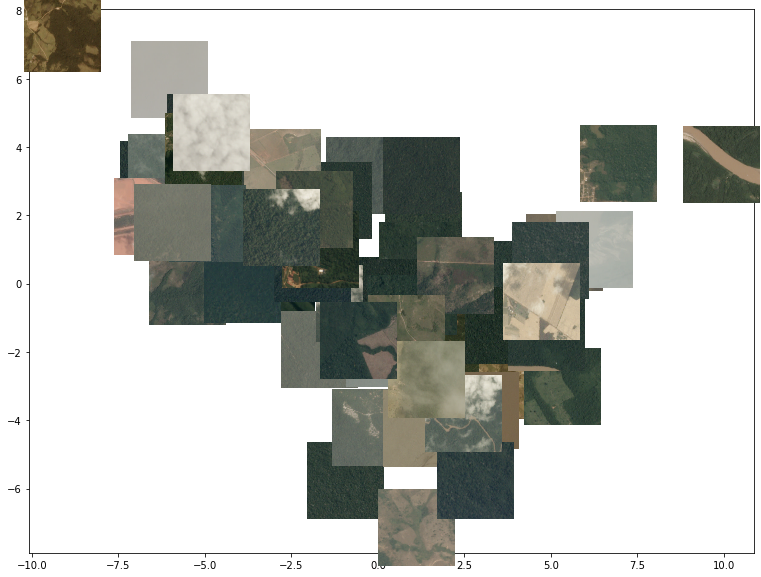

In [28]:
# Subset of images for clustering
n_imgs = 60
offset = 200
image_paths = sorted(glob('../data/train-jpg/*.jpg'))[0:offset + n_imgs]


# Plot the subset of images in a two dimensional representation
def imscatter(x, y, images, ax=None, zoom=0.3):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
imscatter(pca_bigearthnet[offset:offset + n_imgs, 0], pca_bigearthnet[offset:offset + n_imgs, 1], [plt.imread(image_paths[offset + i]) for i in range(n_imgs)])

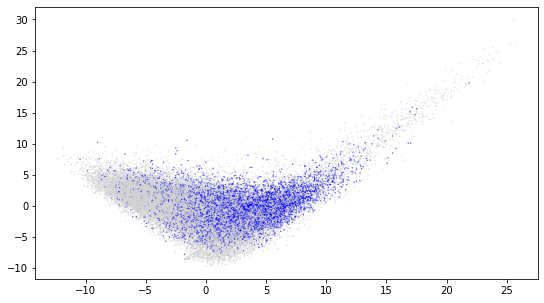

In [29]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_bigearthnet[:, 0], pca_bigearthnet[:, 1], c=color, s=0.1, cmap='Scatter');

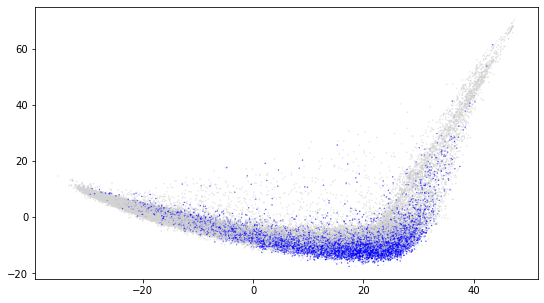

In [30]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_EuroSAT[:, 0], pca_EuroSAT[:, 1], c=color, s=0.1, cmap='Scatter');

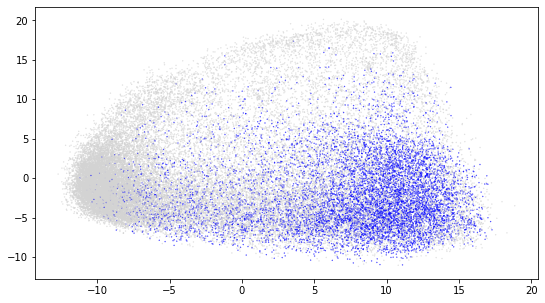

In [31]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_ResNet50[:, 0], pca_ResNet50[:, 1], c=color, s=0.1, cmap='Scatter');

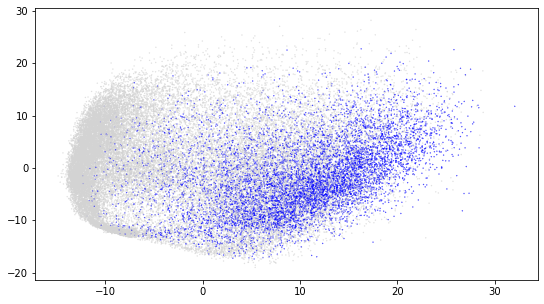

In [32]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_Resic45[:, 0], pca_Resic45[:, 1], c=color, s=0.1, cmap='Scatter');

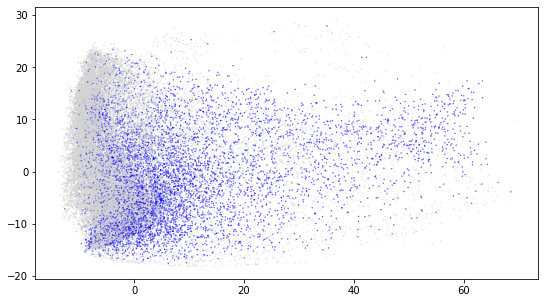

In [33]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_So2Sat[:, 0], pca_So2Sat[:, 1], c=color, s=0.1, cmap='Scatter');

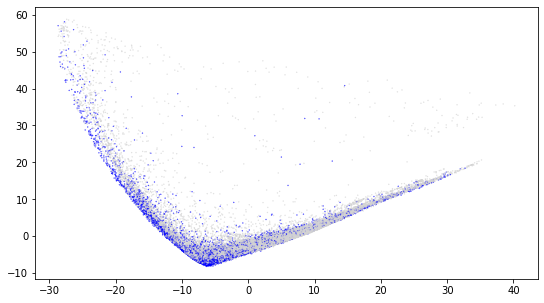

In [34]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_Tile2Vec[:, 0], pca_Tile2Vec[:, 1], c=color, s=0.1, cmap='Scatter');

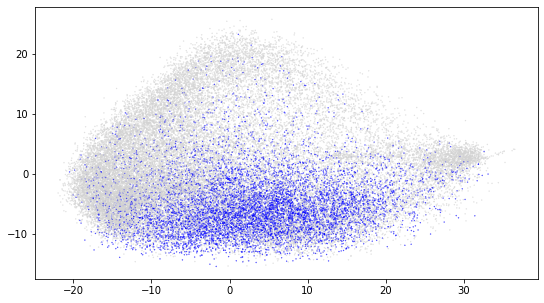

In [35]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_UCMerced[:, 0], pca_UCMerced[:, 1], c=color, s=0.1, cmap='Scatter');

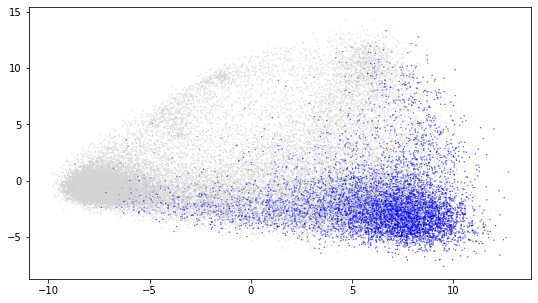

In [36]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(pca_InceptionV3[:, 0], pca_InceptionV3[:, 1], c=color, s=0.1, cmap='Scatter');

##### Weather

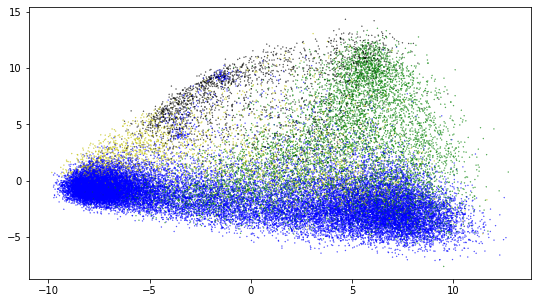

In [37]:
color = []
for i in range(len(y_train)):
    if y_train[i,0] == 1: #haze
        color.append('y')
    elif y_train[i,3] == 1: #clear
        color.append('b')
    elif y_train[i,9] == 1: #cloudy
        color.append('k')
    else: #partly cloudy
        color.append('g')
        
plt.figure(figsize=(9,5))
plt.scatter(pca_InceptionV3[:, 0], pca_InceptionV3[:, 1], c=color, s=0.1, cmap='Spectral');

### UMAP

In [38]:
#umap_bigearthnet = umap.UMAP(
#    n_neighbors=100,
#    min_dist=0.0,
#    n_components=2,
#    random_state=42,
#).fit_transform(features_bigearthnet)

In [39]:
UMAP_KAGGLE = os.path.abspath("../data/features/Kaggle/UMAP")

umap_bigearthnet = np.load(os.path.join(UMAP_KAGGLE, 'umap_bigearthnet.npy'))
umap_EuroSAT = np.load(os.path.join(UMAP_KAGGLE, 'umap_EuroSAT.npy'))
umap_ResNet50 = np.load(os.path.join(UMAP_KAGGLE, 'umap_ResNet50.npy'))
umap_Resic45 = np.load(os.path.join(UMAP_KAGGLE, 'umap_Resic45.npy'))
umap_So2Sat = np.load(os.path.join(UMAP_KAGGLE, 'umap_So2Sat.npy'))
umap_Tile2Vec = np.load(os.path.join(UMAP_KAGGLE, 'umap_Tile2Vec.npy'))
umap_UCMerced = np.load(os.path.join(UMAP_KAGGLE, 'umap_UCMerced.npy'))
umap_InceptionV3 = np.load(os.path.join(UMAP_KAGGLE, 'umap_InceptionV3.npy'))


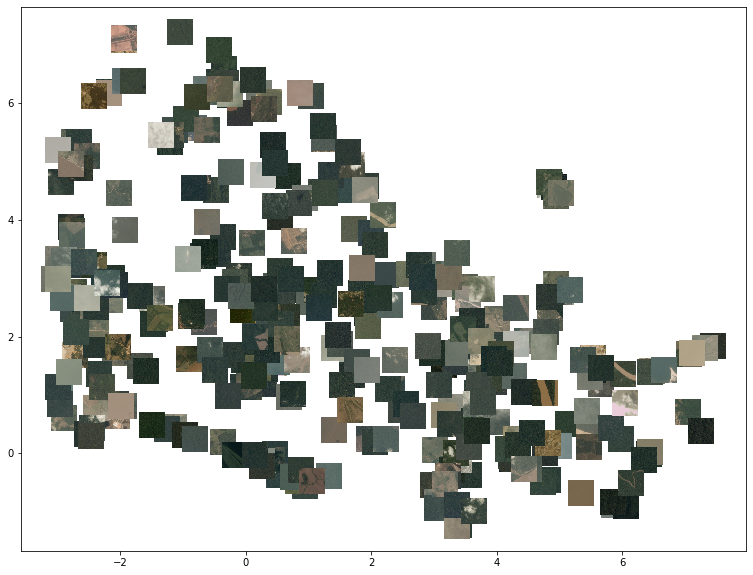

In [40]:
# Plot the subset of images in a two dimensional representation
n_imgs = 350
image_paths = sorted(glob('../data/train-jpg/*.jpg'))[0:n_imgs]


def imscatter(x, y, images, ax=None, zoom=0.1):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
imscatter(umap_bigearthnet[0:n_imgs,0], umap_bigearthnet[0:n_imgs,1], [plt.imread(image_paths[i]) for i in range(n_imgs)])

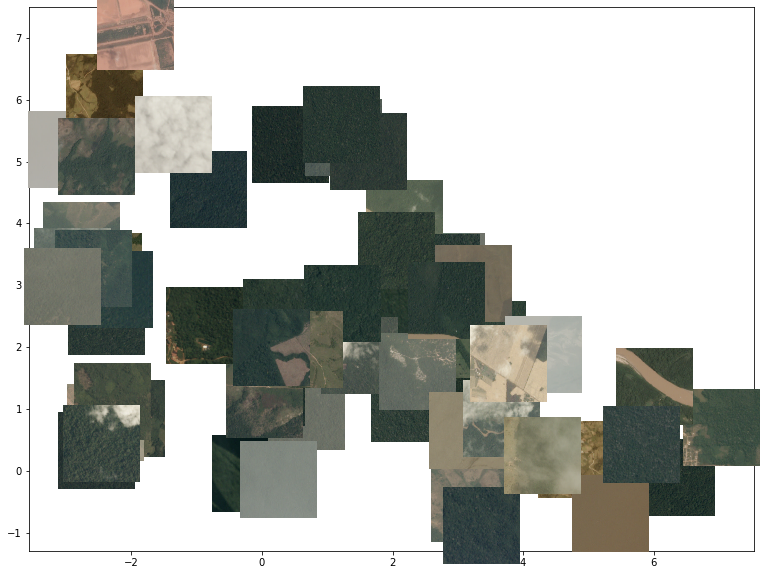

In [41]:
# Subset of images for clustering
n_imgs = 60
offset = 200
image_paths = sorted(glob('../data/train-jpg/*.jpg'))[0:offset + n_imgs]


# Plot the subset of images in a two dimensional representation
def imscatter(x, y, images, ax=None, zoom=0.3):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
imscatter(umap_bigearthnet[offset:offset + n_imgs, 0], umap_bigearthnet[offset:offset + n_imgs, 1], [plt.imread(image_paths[offset + i]) for i in range(n_imgs)])

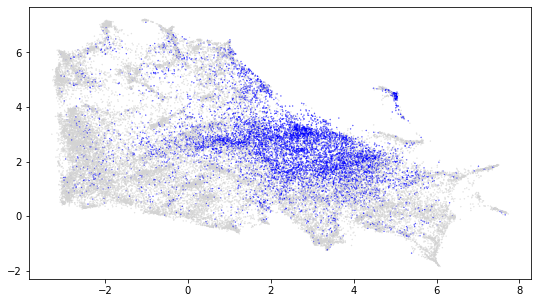

In [42]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_bigearthnet[:, 0], umap_bigearthnet[:, 1], c=color, s=0.1, cmap='Scatter');

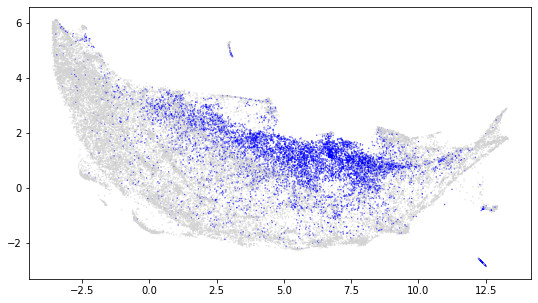

In [43]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_EuroSAT[:, 0], umap_EuroSAT[:, 1], c=color, s=0.1, cmap='Scatter');

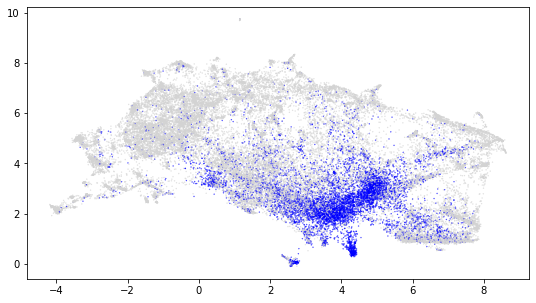

In [44]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_ResNet50[:, 0], umap_ResNet50[:, 1], c=color, s=0.1, cmap='Scatter');

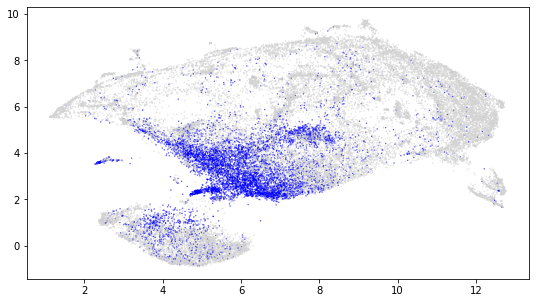

In [45]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_Resic45[:, 0], umap_Resic45[:, 1], c=color, s=0.1, cmap='Scatter');

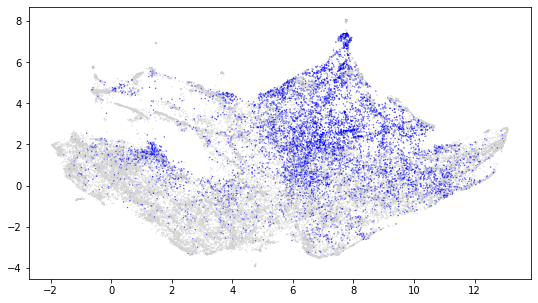

In [46]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_So2Sat[:, 0], umap_So2Sat[:, 1], c=color, s=0.1, cmap='Scatter');

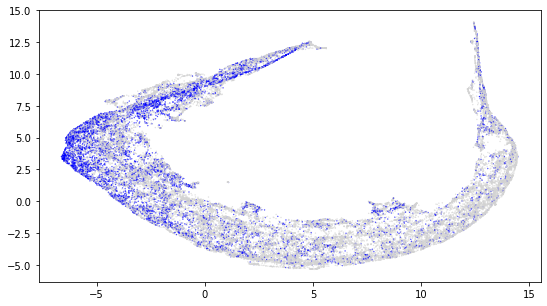

In [47]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_Tile2Vec[:, 0], umap_Tile2Vec[:, 1], c=color, s=0.1, cmap='Scatter');

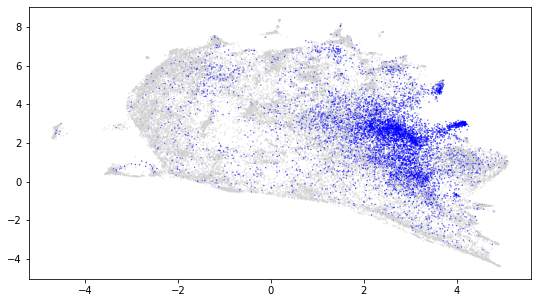

In [48]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_UCMerced[:, 0], umap_UCMerced[:, 1], c=color, s=0.1, cmap='Scatter');

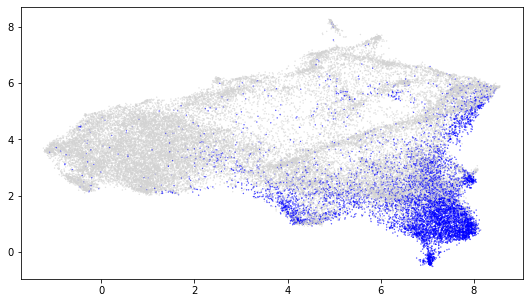

In [49]:
color = []
for i in range(len(y_train)):
    if y_train[i,6] == 1:
        color.append('b') #road
    else:
        color.append('lightgrey') #other

plt.figure(figsize=(9,5))
plt.scatter(umap_InceptionV3[:, 0], umap_InceptionV3[:, 1], c=color, s=0.1, cmap='Scatter');

##### Weather

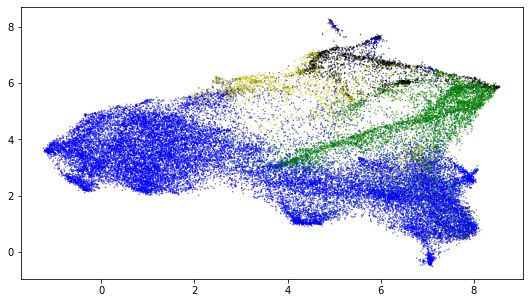

In [50]:
color = []
for i in range(len(y_train)):
    if y_train[i,0] == 1: #haze
        color.append('y')
    elif y_train[i,3] == 1: #clear
        color.append('b')
    elif y_train[i,9] == 1: #cloudy
        color.append('k')
    else: #partly cloudy
        color.append('g')
        
plt.figure(figsize=(9,5))
plt.scatter(umap_InceptionV3[:, 0], umap_InceptionV3[:, 1], c=color, s=0.1, cmap='Spectral');